# Word vectors from SEC filings using Gensim: word2vec model 

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
from time import time
import logging

import numpy as np
import pandas as pd

from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import LineSentence

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
sns.set_style('white')
np.random.seed(42)

In [4]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

### Paths

In [5]:
sec_path = Path('..', 'data', 'sec-filings')
ngram_path = sec_path / 'ngrams'

In [6]:
results_path = Path('results', 'sec-filings')

model_path = results_path / 'models'
if not model_path.exists():
    model_path.mkdir(parents=True)

log_path = results_path / 'logs'
if not log_path.exists():
    log_path.mkdir(parents=True)

### Logging Setup

In [7]:
logging.basicConfig(
    filename=log_path / 'word2vec.log',
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%H:%M:%S')

## word2vec

In [8]:
analogies_path = Path('data', 'analogies-en.txt')

### Set up Sentence Generator

In [9]:
NGRAMS = 2

To facilitate memory-efficient text ingestion, the LineSentence class creates a generator from individual sentences contained in the provided text file:

In [10]:
sentence_path = ngram_path  / f'ngrams_{NGRAMS}.txt'
sentences = LineSentence(sentence_path)

### Train word2vec Model

The [gensim.models.word2vec](https://radimrehurek.com/gensim/models/word2vec.html) class implements the skipgram and CBOW architectures.

In [11]:
start = time()
model = Word2Vec(sentences,
                 sg=1,          # 1 for skip-gram; otherwise CBOW
                 hs=0,          # hierarchical softmax if 1, negative sampling if 0
                 size=300,      # Vector dimensionality
                 window=5,      # Max distance betw. current and predicted word
                 min_count=50,  # Ignore words with lower frequency
                 negative=15,    # noise word count for negative sampling
                 workers=4,     # no threads 
                 iter=1,        # no epochs = iterations over corpus
                 alpha=0.05,   # initial learning rate
                 min_alpha=0.0001 # final learning rate
                ) 
print('Duration:', format_time(time() - start))

Duration: 01:09:42


### Persist model & vectors

In [13]:
model.save((model_path / 'word2vec_0.model').as_posix())
model.wv.save((model_path / 'word_vectors_0.bin').as_posix())

### Load model and vectors

In [13]:
model = Word2Vec.load((model_path / 'word2vec_0.model').as_posix())

In [14]:
wv = KeyedVectors.load((model_path / 'word_vectors_0.bin').as_posix())

### Get vocabulary

In [15]:
vocab = []
for k, _ in model.wv.vocab.items():
    v_ = model.wv.vocab[k]
    vocab.append([k, v_.index, v_.count])

In [16]:
vocab = (pd.DataFrame(vocab, 
                     columns=['token', 'idx', 'count'])
         .sort_values('count', ascending=False))

In [17]:
vocab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57384 entries, 492 to 56111
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   token   57384 non-null  object
 1   idx     57384 non-null  int64 
 2   count   57384 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ MB


In [18]:
vocab.head(10)

,token,idx,count
492,million,0,2340187
0,business,1,1696732
646,december,2,1512367
141,company,3,1490617
90,products,4,1367413
2134,net,5,1246820
335,market,6,1148002
431,including,7,1109821
460,sales,8,1095619
302,costs,9,1018821


In [19]:
vocab['count'].describe(percentiles=np.arange(.1, 1, .1)).astype(int)

count      57384
mean        4523
std        35191
min           50
10%           60
20%           75
30%           96
40%          128
50%          176
60%          263
70%          442
80%          946
90%         3666
max      2340187
Name: count, dtype: int64

### Evaluate Analogies

In [20]:
def accuracy_by_category(acc, detail=True):
    results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in acc]
    results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
    results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
    if detail:
        print(results.sort_values('average', ascending=False))
    return results.loc[results.category=='total', ['correct', 'incorrect', 'average']].squeeze().tolist()

In [21]:
detailed_accuracy = model.wv.accuracy(analogies_path.as_posix(), case_insensitive=True)

In [22]:
summary = accuracy_by_category(detailed_accuracy)

                       category  correct  incorrect   average
10  gram6-nationality-adjective      433        360  0.546028
12                 gram8-plural      251        349  0.418333
7             gram3-comparative      266        604  0.305747
14                        total     1877       4563  0.291460
13           gram9-plural-verbs       89        217  0.290850
9      gram5-present-participle      110        270  0.289474
3                 city-in-state      428       1262  0.253254
6                gram2-opposite       53        157  0.252381
11             gram7-past-tense      133        517  0.204615
5     gram1-adjective-to-adverb       61        245  0.199346
8             gram4-superlative       32        208  0.133333
0      capital-common-countries       11         99  0.100000
1                 capital-world        7         96  0.067961
4                        family        1         29  0.033333
2                      currency        2        150  0.013158


In [23]:
def eval_analogies(w2v, max_vocab=15000):
    accuracy = w2v.wv.accuracy(analogies_path,
                               restrict_vocab=15000,
                               case_insensitive=True)
    return (pd.DataFrame([[c['section'],
                        len(c['correct']),
                        len(c['incorrect'])] for c in accuracy],
                      columns=['category', 'correct', 'incorrect'])
          .assign(average=lambda x: 
                  x.correct.div(x.correct.add(x.incorrect))))  

In [24]:
def total_accuracy(w2v):
    df = eval_analogies(w2v)
    return df.loc[df.category == 'total', ['correct', 'incorrect', 'average']].squeeze().tolist()

In [25]:
accuracy = eval_analogies(model)
accuracy

,category,correct,incorrect,average
0,capital-common-countries,1,11,0.083333
1,capital-world,1,2,0.333333
2,currency,1,51,0.019231
3,city-in-state,117,290,0.287469
4,family,0,0,NaN
5,gram1-adjective-to-adverb,42,168,0.200000
6,gram2-opposite,22,68,0.244444
7,gram3-comparative,225,375,0.375000
8,gram4-superlative,13,77,0.144444
9,gram5-present-participle,98,208,0.320261


### Validate Vector Arithmetic

In [26]:
sims=model.wv.most_similar(positive=['iphone'], restrict_vocab=15000)
print(pd.DataFrame(sims, columns=['term', 'similarity']))

                  term  similarity
0                 ipad    0.717832
1              android    0.623469
2          smartphones    0.611048
3           smartphone    0.597099
4                  app    0.594423
5  smartphones_tablets    0.564472
6              desktop    0.558632
7       mobile_devices    0.551297
8          smart_phone    0.549199
9             keyboard    0.545658


In [27]:
analogy = model.wv.most_similar(positive=['france', 'london'], 
                                negative=['paris'], 
                                restrict_vocab=15000)
print(pd.DataFrame(analogy, columns=['term', 'similarity']))

             term  similarity
0  united_kingdom    0.538912
1         germany    0.536953
2       singapore    0.521441
3         belgium    0.508939
4       australia    0.508507
5           italy    0.502509
6          brazil    0.500618
7     netherlands    0.495929
8          poland    0.495847
9  czech_republic    0.495551


### Check similarity for random words

In [28]:
VALID_SET = 5  # Random set of words to get nearest neighbors for
VALID_WINDOW = 100  # Most frequent words to draw validation set from
valid_examples = np.random.choice(VALID_WINDOW, size=VALID_SET, replace=False)
similars = pd.DataFrame()

for id in sorted(valid_examples):
    word = vocab.loc[id, 'token']
    similars[word] = [s[0] for s in model.wv.most_similar(word)]
similars

,harmed,undertake_obligation,references,solutions,compact
0,harm,update_revise,context_requires,solution,bib
1,suffer,undertakes_obligation,context_indicates,automation,mouthpiece
2,adversely_affected,obligation_update,context_suggests,platform,gasjack
3,seriously_harmed,disclaim_obligation,refer,primesuite,gpsmap
4,negatively_affect,statement_speaks,matador,technologies,diverter
5,materially_adversely,disclaims_obligation,meanings,veeva_crm,gantry
6,adverse_effect,expressly_disclaim,brief_summaries,best_breed,versatile
7,adversely_affect,statements_speak,references_urls,veeva,oled_xl
8,negatively_impact,expressly_disclaims,acronyms,cloud,trailer_mounted
9,hurt,speak_date,lone_pine,mobile,femtosecond


## Continue Training

In [29]:
accuracies = [summary]
best_accuracy = summary[-1]
for i in range(1, 15):
    start = time()
    model.train(sentences, epochs=1, total_examples=model.corpus_count)
    detailed_accuracy = model.wv.accuracy(analogies_path)
    accuracies.append(accuracy_by_category(detailed_accuracy, detail=False))
    print(f'{i:02} | Duration: {format_time(time() - start)} | Accuracy: {accuracies[-1][-1]:.2%} ')
    if accuracies[-1][-1] > best_accuracy:
        model.save((model_path / f'word2vec_{i:02}.model').as_posix())
        model.wv.save((model_path / f'word_vectors_{i:02}.bin').as_posix())
        best_accuracy = accuracies[-1][-1]
    (pd.DataFrame(accuracies, 
                 columns=['correct', 'wrong', 'average'])
     .to_csv(model_path / 'accuracies.csv', index=False))
model.wv.save((model_path / 'word_vectors_final.bin').as_posix())

01 | Duration: 00:46:24 | Accuracy: 31.24% 
02 | Duration: 00:40:43 | Accuracy: 32.50% 
03 | Duration: 00:40:19 | Accuracy: 31.93% 
04 | Duration: 00:40:17 | Accuracy: 33.26% 
05 | Duration: 00:40:14 | Accuracy: 34.38% 
06 | Duration: 00:40:11 | Accuracy: 33.39% 
07 | Duration: 00:40:14 | Accuracy: 32.78% 
08 | Duration: 00:40:30 | Accuracy: 33.74% 
09 | Duration: 00:40:08 | Accuracy: 34.91% 
10 | Duration: 00:40:06 | Accuracy: 33.32% 
11 | Duration: 00:40:07 | Accuracy: 33.23% 
12 | Duration: 00:40:05 | Accuracy: 33.25% 
13 | Duration: 00:40:09 | Accuracy: 34.33% 
14 | Duration: 00:40:16 | Accuracy: 34.63% 


### Sample Output


|Epoch|Duration| Accuracy|
|---|---|---|
01 | 00:14:00 | 31.64% | 
02 | 00:14:21 | 31.72% | 
03 | 00:14:34 | 33.65% | 
04 | 00:16:11 | 34.03% | 
05 | 00:13:51 | 33.04% | 
06 | 00:13:46 | 33.28% | 
07 | 00:13:51 | 33.10% | 
08 | 00:13:54 | 34.11% | 
09 | 00:13:54 | 33.70% | 
10 | 00:13:55 | 34.09% | 
11 | 00:13:57 | 35.06% | 
12 | 00:13:38 | 33.79% | 
13 | 00:13:26 | 32.40% | 

In [33]:
model_path

PosixPath('results/sec-filings/models')

In [46]:
acc_df = pd.DataFrame(accuracies, columns=['correct', 'wrong', 'average'])
best_modeld_idx = acc_df['average'].idxmax()
print(best_modeld_idx)

9


In [47]:
acc_df.sort_values(by='average', ascending=False).head(3)

,correct,wrong,average
9,2248.0,4192.0,0.349068
14,2230.0,4210.0,0.346273
5,2214.0,4226.0,0.343789


In [30]:
(pd.DataFrame(accuracies, 
             columns=['correct', 'wrong', 'average'])
 .to_csv(results_path / 'accuracies.csv', index=False))

In [54]:
best_model = Word2Vec.load((model_path / f'word2vec_{best_modeld_idx:0>2}.model').as_posix())

In [55]:
detailed_accuracy = best_model.wv.accuracy(analogies_path.as_posix(), case_insensitive=True)

In [56]:
summary = accuracy_by_category(detailed_accuracy)
print('Base Accuracy: Correct {:,.0f} | Wrong {:,.0f} | Avg {:,.2%}\n'.format(*summary))

                       category  correct  incorrect   average
10  gram6-nationality-adjective      478        315  0.602774
12                 gram8-plural      269        331  0.448333
3                 city-in-state      655       1035  0.387574
7             gram3-comparative      323        547  0.371264
14                        total     2248       4192  0.349068
9      gram5-present-participle      130        250  0.342105
13           gram9-plural-verbs       81        225  0.264706
11             gram7-past-tense      137        513  0.210769
6                gram2-opposite       42        168  0.200000
5     gram1-adjective-to-adverb       58        248  0.189542
0      capital-common-countries       17         93  0.154545
8             gram4-superlative       36        204  0.150000
1                 capital-world       15         88  0.145631
4                        family        4         26  0.133333
2                      currency        3        149  0.019737
Base Acc

In [57]:
cat_dict = {'capital-common-countries':'Capitals',
            'capital-world':'Capitals RoW',
            'city-in-state':'City-State',
            'currency':'Currency',
            'family':'Famliy',
            'gram1-adjective-to-adverb':'Adj-Adverb',
            'gram2-opposite':'Opposite',
            'gram3-comparative':'Comparative',
            'gram4-superlative':'Superlative',
            'gram5-present-participle':'Pres. Part.',
            'gram6-nationality-adjective':'Nationality',
            'gram7-past-tense':'Past Tense',
            'gram8-plural':'Plural',
            'gram9-plural-verbs':'Plural Verbs',
            'total':'Total'}

In [58]:
results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in detailed_accuracy]
results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
results['category'] = results.category.map(cat_dict)
results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
results = results.rename(columns=str.capitalize).set_index('Category')
total = results.loc['Total']
results = results.drop('Total')

In [59]:
most_sim = best_model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=20)
pd.DataFrame(most_sim, columns=['token', 'similarity'])

,token,similarity
0,women,0.395165
1,spalding,0.353391
2,kitsap,0.345401
3,clark,0.343434
4,kornberg,0.341189
5,men,0.340918
6,pregnancy,0.340273
7,queen,0.337880
8,female,0.335644
9,mclean,0.334633


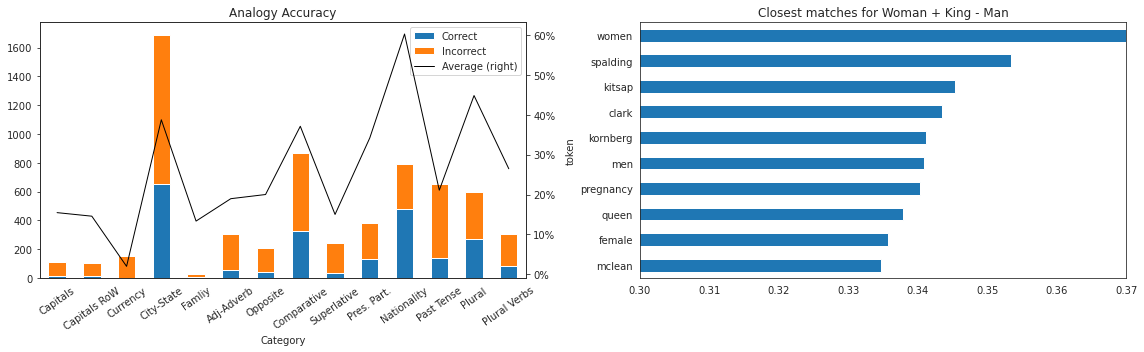

In [60]:
fig, axes = plt.subplots(figsize=(16, 5), ncols=2)

axes[0] = results.loc[:, ['Correct', 'Incorrect']].plot.bar(stacked=True, ax=axes[0]
                                                           , title='Analogy Accuracy')
ax1 = results.loc[:, ['Average']].plot(ax=axes[0], secondary_y=True, lw=1, c='k', rot=35)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

(pd.DataFrame(most_sim, columns=['token', 'similarity'])
 .set_index('token').similarity
 .sort_values().tail(10).plot.barh(xlim=(.3, .37), ax=axes[1], title='Closest matches for Woman + King - Man'))
fig.tight_layout()
# fig.savefig('figures/w2v_sec_evaluation', dpi=300);